In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
import random

In [2]:


def _return_float_dtype(X, Y):
    """
    1. If dtype of X and Y is float32, then dtype float32 is returned.
    2. Else dtype float is returned.
    """
    if not issparse(X) and not isinstance(X, np.ndarray):
        X = np.asarray(X)

    if Y is None:
        Y_dtype = X.dtype
    elif not issparse(Y) and not isinstance(Y, np.ndarray):
        Y = np.asarray(Y)
        Y_dtype = Y.dtype
    else:
        Y_dtype = Y.dtype

    if X.dtype == Y_dtype == np.float32:
        dtype = np.float32
    elif X.dtype == np.object and not issparse(X):
        dtype = np.float
        for col in range(X.shape[1]):
            if not np.issubdtype(type(X[0, col]), np.number):
                dtype = np.object
                break
    else:
        dtype = np.float

    return X, Y, dtype


def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = _return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float


    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y

In [3]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])

    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]

    return dm




In [4]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])

    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]

    return dm




In [5]:
HotelUnclustered= pd.read_csv("Hotel_Reviews.csv",usecols=[4,5,7,8,10,11,12,15,16]) 
HotelUnclustered=HotelUnclustered.dropna() 


In [6]:
def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')
    # randomly initialize an array of k medoid indices
    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in range(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

In [7]:
def sampleFromDatFrame(inDataFrame,keyWord, sampleRatio = 0.001, column = 'Hotel_Name'):
    odf = inDataFrame.loc[inDataFrame[column] == keyWord]
    #odf=inDataFrame
    odf = odf.iloc[np.random.choice(odf.shape[0], int(odf.shape[0] * sampleRatio))]
    
    return odf

In [8]:
coulmn=HotelUnclustered.columns

AllHotels=HotelUnclustered.Hotel_Name.unique()
selected_reviews=pd.DataFrame(columns=coulmn)
for Hotel in AllHotels:
    df=sampleFromDatFrame(HotelUnclustered,Hotel)

    selected_reviews = pd.concat([selected_reviews,df])

In [9]:

selected_reviews=selected_reviews.take([1,2,3,4,5,6,7,8],axis=1)
selected_reviews.head()

,Reviewer_Nationality,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
989,United States of America,15,2619,11,6,9.6,51.513734,-0.108751
2485,United Kingdom,0,4380,57,4,9.6,51.514218,-0.180903
4124,Poland,25,3150,15,4,9.2,51.522622,-0.125160
6720,United Kingdom,6,6117,7,1,8.8,51.501400,-0.116009
7432,United Kingdom,0,6117,10,2,9.2,51.501400,-0.116009


In [10]:
selected_reviews.shape[0]

128

In [11]:
D = gower_distances(selected_reviews)
print(D)


[[ 0.          0.20987718  0.15500231 ...,  0.34838169  0.18241054
   0.19360618]
 [ 0.20987718  0.          0.20973881 ...,  0.35491485  0.2275589
   0.19944796]
 [ 0.15500231  0.20973881  0.         ...,  0.33071589  0.18970416
   0.19347881]
 ..., 
 [ 0.34838169  0.35491485  0.33071589 ...,  0.          0.3171535
   0.34990625]
 [ 0.18241054  0.2275589   0.18970416 ...,  0.3171535   0.          0.18430141]
 [ 0.19360618  0.19944796  0.19347881 ...,  0.34990625  0.18430141  0.        ]]


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

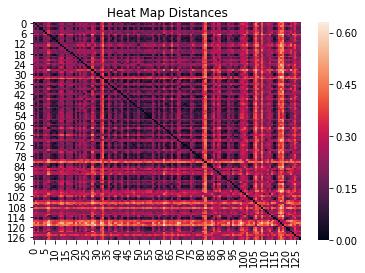

In [13]:
sns.heatmap(D)
plt.title("Heat Map Distances")
plt.show()

In [14]:

from sklearn.metrics import silhouette_score

In [15]:
labels=np.zeros(D.shape[0])
sil_rating=np.array([])
for no_cluster in range(2, 15):
    M, C = kMedoids(D, no_cluster)
    
    for label in C:
        for point_idx in C[label]:
            labels[point_idx]=label
    
    sil_rating=np.append(sil_rating,silhouette_score(D,labels))

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

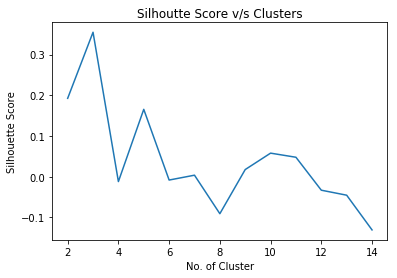

In [17]:
plt.plot(range(2, 15),sil_rating)
plt.xlabel('No. of Cluster')
plt.ylabel('Silhouette Score')
plt.title("Silhoutte Score v/s Clusters");
plt.show()

In [18]:
optimum_no_cluster=sil_rating.argmax()+2
optimum_no_cluster

3

In [19]:
M, C = kMedoids(D, 5)
for label in C:
    for point_idx in C[label]:
        labels[point_idx]=label

In [20]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
model = MDS(n_components=3, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)


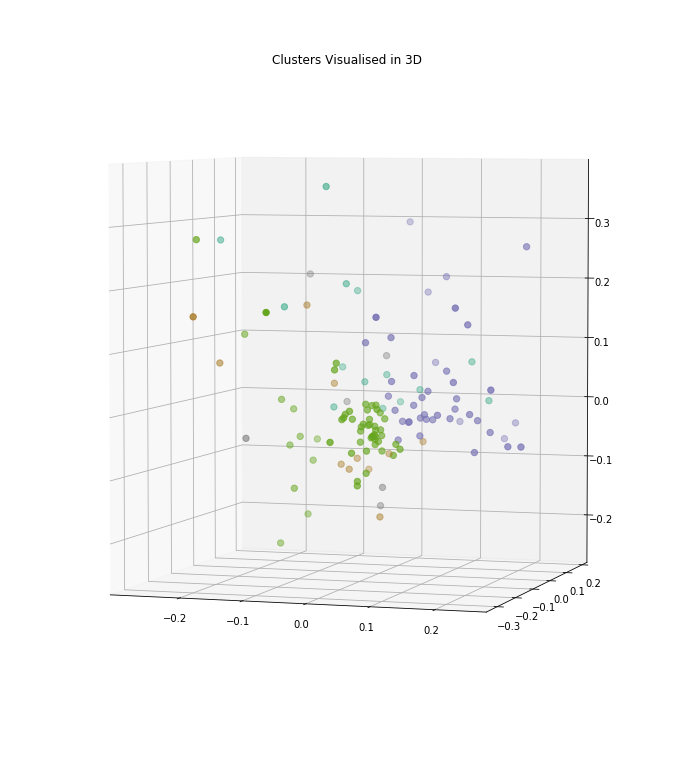

In [21]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
Axes3D

fig = plt.figure(figsize=(70, 30))
ax = fig.add_subplot(251, projection='3d')
ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=labels, cmap=plt.cm.Dark2, s=40)
ax.view_init(4, -72)
plt.title("Clusters Visualised in 3D")
plt.show()

In [22]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)


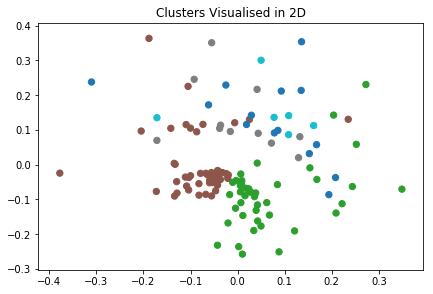

In [23]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(251)
ax.scatter(out[:, 0], out[:, 1], c=labels, cmap=plt.cm.tab10, s=40)

plt.title("Clusters Visualised in 2D")
plt.show()

In [31]:
for point_idx in M:
    print( selected_reviews.iloc[point_idx,:] )

Reviewer_Nationality                           Malaysia 
Review_Total_Negative_Word_Counts                     10
Total_Number_of_Reviews                             7105
Review_Total_Positive_Word_Counts                      9
Total_Number_of_Reviews_Reviewer_Has_Given             5
Reviewer_Score                                       7.9
lat                                               51.499
lng                                            -0.191707
Name: 444555, dtype: object
Reviewer_Nationality                           United Kingdom 
Review_Total_Negative_Word_Counts                           11
Total_Number_of_Reviews                                   3826
Review_Total_Positive_Word_Counts                            6
Total_Number_of_Reviews_Reviewer_Has_Given                   1
Reviewer_Score                                             6.7
lat                                                    51.5043
lng                                                 -0.0334436
Name: 125875

In [32]:
column=selected_reviews.columns
ClusterCentroid = pd.DataFrame(columns=column)

In [131]:
ClusterCentroid =selected_reviews.iloc[M]
ClusterCentroidSummary=ClusterCentroid.reset_index()

In [132]:
Cluster0 =selected_reviews.iloc[C[0]]
Cluster1 =selected_reviews.iloc[C[1]]
Cluster2 =selected_reviews.iloc[C[2]]
Cluster3 =selected_reviews.iloc[C[3]]
Cluster4 =selected_reviews.iloc[C[4]]

In [133]:
avg_neg_word=np.array([Cluster0['Review_Total_Negative_Word_Counts'].mean(),Cluster1['Review_Total_Negative_Word_Counts'].mean(),Cluster2['Review_Total_Negative_Word_Counts'].mean(),Cluster3['Review_Total_Negative_Word_Counts'].mean(),Cluster4['Review_Total_Negative_Word_Counts'].mean()])
avg_pos_word=np.array([Cluster0['Review_Total_Positive_Word_Counts'].mean(),Cluster1['Review_Total_Positive_Word_Counts'].mean(),Cluster2['Review_Total_Positive_Word_Counts'].mean(),Cluster3['Review_Total_Positive_Word_Counts'].mean(),Cluster4['Review_Total_Positive_Word_Counts'].mean()])

In [134]:
avg_totalreview=np.array([Cluster0['Total_Number_of_Reviews'].mean(),Cluster1['Total_Number_of_Reviews'].mean(),Cluster2['Total_Number_of_Reviews'].mean(),Cluster3['Total_Number_of_Reviews'].mean(),Cluster4['Total_Number_of_Reviews'].mean()])
avg_reviewGivenByReviver=np.array([Cluster0['Total_Number_of_Reviews_Reviewer_Has_Given'].mean(),Cluster1['Total_Number_of_Reviews_Reviewer_Has_Given'].mean(),Cluster2['Total_Number_of_Reviews_Reviewer_Has_Given'].mean(),Cluster3['Total_Number_of_Reviews_Reviewer_Has_Given'].mean(),Cluster4['Total_Number_of_Reviews_Reviewer_Has_Given'].mean()])

In [135]:
avg_review_score=np.array([Cluster0['Reviewer_Score'].mean(),Cluster1['Reviewer_Score'].mean(),Cluster2['Reviewer_Score'].mean(),Cluster3['Reviewer_Score'].mean(),Cluster4['Reviewer_Score'].mean()])
avg_lat=np.array([Cluster0['lat'].mean(),Cluster1['lat'].mean(),Cluster2['lat'].mean(),Cluster3['lat'].mean(),Cluster4['lat'].mean()])
avg_lng=np.array([Cluster0['lng'].mean(),Cluster1['lng'].mean(),Cluster2['lng'].mean(),Cluster3['lng'].mean(),Cluster4['lng'].mean()])

In [136]:
column=['Neg_Word_Count',
 'Total_Review',
 'Pos_Word_Count',
 'Reviews_givenby_Reviewer',
 'Score',
 'lat',
 'lng']

In [137]:
ClusterSummaryAvg=pd.DataFrame(np.column_stack((avg_neg_word,avg_totalreview,avg_pos_word,avg_reviewGivenByReviver,avg_review_score,avg_lat,avg_lng)),columns=column)

In [106]:
avg_neg_word=np.array([Cluster0['Review_Total_Negative_Word_Counts'].max(),Cluster1['Review_Total_Negative_Word_Counts'].max(),Cluster2['Review_Total_Negative_Word_Counts'].max(),Cluster3['Review_Total_Negative_Word_Counts'].max(),Cluster4['Review_Total_Negative_Word_Counts'].max()])
avg_pos_word=np.array([Cluster0['Review_Total_Positive_Word_Counts'].max(),Cluster1['Review_Total_Positive_Word_Counts'].max(),Cluster2['Review_Total_Positive_Word_Counts'].max(),Cluster3['Review_Total_Positive_Word_Counts'].max(),Cluster4['Review_Total_Positive_Word_Counts'].max()])

In [107]:
avg_totalreview=np.array([Cluster0['Total_Number_of_Reviews'].max(),Cluster1['Total_Number_of_Reviews'].max(),Cluster2['Total_Number_of_Reviews'].max(),Cluster3['Total_Number_of_Reviews'].max(),Cluster4['Total_Number_of_Reviews'].max()])
avg_reviewGivenByReviver=np.array([Cluster0['Total_Number_of_Reviews_Reviewer_Has_Given'].max(),Cluster1['Total_Number_of_Reviews_Reviewer_Has_Given'].max(),Cluster2['Total_Number_of_Reviews_Reviewer_Has_Given'].max(),Cluster3['Total_Number_of_Reviews_Reviewer_Has_Given'].max(),Cluster4['Total_Number_of_Reviews_Reviewer_Has_Given'].max()])

In [140]:
avg_review_score=np.array([Cluster0['Reviewer_Score'].max(),Cluster1['Reviewer_Score'].max(),Cluster2['Reviewer_Score'].max(),Cluster3['Reviewer_Score'].max(),Cluster4['Reviewer_Score'].max()])
avg_lat=np.array([Cluster0['lat'].max(),Cluster1['lat'].max(),Cluster2['lat'].max(),Cluster3['lat'].max(),Cluster4['lat'].max()])
avg_lng=np.array([Cluster0['lng'].max(),Cluster1['lng'].max(),Cluster2['lng'].max(),Cluster3['lng'].max(),Cluster4['lng'].max()])

In [141]:
ClusterSummaryMax=pd.DataFrame(np.column_stack((avg_neg_word,avg_totalreview,avg_pos_word,avg_reviewGivenByReviver,avg_review_score,avg_lat,avg_lng)),columns=column)

In [142]:
avg_neg_word=np.array([Cluster0['Review_Total_Negative_Word_Counts'].min(),Cluster1['Review_Total_Negative_Word_Counts'].min(),Cluster2['Review_Total_Negative_Word_Counts'].min(),Cluster3['Review_Total_Negative_Word_Counts'].min(),Cluster4['Review_Total_Negative_Word_Counts'].min()])
avg_pos_word=np.array([Cluster0['Review_Total_Positive_Word_Counts'].min(),Cluster1['Review_Total_Positive_Word_Counts'].min(),Cluster2['Review_Total_Positive_Word_Counts'].min(),Cluster3['Review_Total_Positive_Word_Counts'].min(),Cluster4['Review_Total_Positive_Word_Counts'].min()])

In [143]:
avg_totalreview=np.array([Cluster0['Total_Number_of_Reviews'].min(),Cluster1['Total_Number_of_Reviews'].min(),Cluster2['Total_Number_of_Reviews'].min(),Cluster3['Total_Number_of_Reviews'].min(),Cluster4['Total_Number_of_Reviews'].min()])
avg_reviewGivenByReviver=np.array([Cluster0['Total_Number_of_Reviews_Reviewer_Has_Given'].min(),Cluster1['Total_Number_of_Reviews_Reviewer_Has_Given'].min(),Cluster2['Total_Number_of_Reviews_Reviewer_Has_Given'].min(),Cluster3['Total_Number_of_Reviews_Reviewer_Has_Given'].min(),Cluster4['Total_Number_of_Reviews_Reviewer_Has_Given'].min()])

In [144]:
avg_review_score=np.array([Cluster0['Reviewer_Score'].min(),Cluster1['Reviewer_Score'].min(),Cluster2['Reviewer_Score'].min(),Cluster3['Reviewer_Score'].min(),Cluster4['Reviewer_Score'].min()])
avg_lat=np.array([Cluster0['lat'].min(),Cluster1['lat'].min(),Cluster2['lat'].min(),Cluster3['lat'].min(),Cluster4['lat'].min()])
avg_lng=np.array([Cluster0['lng'].min(),Cluster1['lng'].min(),Cluster2['lng'].min(),Cluster3['lng'].min(),Cluster4['lng'].min()])

In [146]:
ClusterSummaryMin=pd.DataFrame(np.column_stack((avg_neg_word,avg_totalreview,avg_pos_word,avg_reviewGivenByReviver,avg_review_score,avg_lat,avg_lng)),columns=column)

In [148]:
avg_neg_word=np.array([Cluster0['Review_Total_Negative_Word_Counts'].std(),Cluster1['Review_Total_Negative_Word_Counts'].std(),Cluster2['Review_Total_Negative_Word_Counts'].std(),Cluster3['Review_Total_Negative_Word_Counts'].std(),Cluster4['Review_Total_Negative_Word_Counts'].std()])
avg_pos_word=np.array([Cluster0['Review_Total_Positive_Word_Counts'].std(),Cluster1['Review_Total_Positive_Word_Counts'].std(),Cluster2['Review_Total_Positive_Word_Counts'].std(),Cluster3['Review_Total_Positive_Word_Counts'].std(),Cluster4['Review_Total_Positive_Word_Counts'].std()])

In [147]:
avg_totalreview=np.array([Cluster0['Total_Number_of_Reviews'].std(),Cluster1['Total_Number_of_Reviews'].std(),Cluster2['Total_Number_of_Reviews'].std(),Cluster3['Total_Number_of_Reviews'].std(),Cluster4['Total_Number_of_Reviews'].std()])
avg_reviewGivenByReviver=np.array([Cluster0['Total_Number_of_Reviews_Reviewer_Has_Given'].std(),Cluster1['Total_Number_of_Reviews_Reviewer_Has_Given'].std(),Cluster2['Total_Number_of_Reviews_Reviewer_Has_Given'].std(),Cluster3['Total_Number_of_Reviews_Reviewer_Has_Given'].std(),Cluster4['Total_Number_of_Reviews_Reviewer_Has_Given'].std()])

In [149]:
avg_review_score=np.array([Cluster0['Reviewer_Score'].min(),Cluster1['Reviewer_Score'].std(),Cluster2['Reviewer_Score'].std(),Cluster3['Reviewer_Score'].std(),Cluster4['Reviewer_Score'].std()])
avg_lat=np.array([Cluster0['lat'].std(),Cluster1['lat'].std(),Cluster2['lat'].std(),Cluster3['lat'].std(),Cluster4['lat'].std()])
avg_lng=np.array([Cluster0['lng'].std(),Cluster1['lng'].std(),Cluster2['lng'].std(),Cluster3['lng'].std(),Cluster4['lng'].std()])

In [155]:
ClusterSummaryStd=pd.DataFrame(np.column_stack((avg_neg_word,avg_totalreview,avg_pos_word,avg_reviewGivenByReviver,avg_review_score,avg_lat,avg_lng)),columns=column)

In [151]:
ClusterSummaryMin

,Neg_Word_Count,Total_Review,Pos_Word_Count,Reviews_givenby_Reviewer,Score,lat,lng
0,19.237098,1315.538566,16.167394,2.312175,3.800000,3.128204,3.018784
1,35.789397,2268.610462,19.470995,6.687873,1.685886,1.700808,1.821008
2,12.570823,3034.591698,16.171784,5.182852,0.339855,1.155373,2.054227
3,11.771306,1073.766921,15.238110,4.319091,0.665378,1.902651,3.213737
4,28.694366,3529.431366,7.678976,6.377042,0.591326,0.346948,2.050480


In [152]:
ClusterSummaryAvg

,Neg_Word_Count,Total_Review,Pos_Word_Count,Reviews_givenby_Reviewer,Score,lat,lng
0,24.285714,6588.785714,17.000000,4.500000,7.214286,50.537179,1.755150
1,29.261905,4442.500000,12.380952,4.833333,5.878571,51.268811,0.752467
2,7.581818,5096.454545,16.745455,4.090909,9.752727,51.337503,0.486821
3,12.181818,3517.000000,15.000000,4.636364,8.754545,51.124081,1.620487
4,29.166667,7093.833333,19.166667,11.666667,8.483333,51.646612,0.729046


In [153]:
ClusterSummaryMax

,Neg_Word_Count,Total_Review,Pos_Word_Count,Reviews_givenby_Reviewer,Score,lat,lng
0,4.0,3609.0,2.0,1.0,3.8,41.411006,-0.192879
1,0.0,2061.0,0.0,1.0,2.5,41.371308,-0.286495
2,0.0,1827.0,2.0,1.0,8.8,45.525722,-0.283526
3,0.0,2485.0,2.0,1.0,7.5,45.482669,-0.224423
4,0.0,2898.0,12.0,7.0,7.5,51.495666,-0.175737


In [156]:
ClusterSummaryStd

,Neg_Word_Count,Total_Review,Pos_Word_Count,Reviews_givenby_Reviewer,Score,lat,lng
0,19.237098,1315.538566,16.167394,2.312175,3.800000,3.128204,3.018784
1,35.789397,2268.610462,19.470995,6.687873,1.685886,1.700808,1.821008
2,12.570823,3034.591698,16.171784,5.182852,0.339855,1.155373,2.054227
3,11.771306,1073.766921,15.238110,4.319091,0.665378,1.902651,3.213737
4,28.694366,3529.431366,7.678976,6.377042,0.591326,0.346948,2.050480


In [158]:
ClusterSummaryDistance=ClusterSummaryStd.divide(ClusterSummaryAvg, axis='columns', level=None, fill_value=None)

In [159]:
ClusterSummaryDistance

,Neg_Word_Count,Total_Review,Pos_Word_Count,Reviews_givenby_Reviewer,Score,lat,lng
0,0.792116,0.199663,0.951023,0.513817,0.526733,0.061899,1.719958
1,1.223071,0.510661,1.572657,1.383698,0.286785,0.033174,2.420052
2,1.658022,0.595432,0.965742,1.266919,0.034847,0.022505,4.219677
3,0.966301,0.305308,1.015874,0.931569,0.076004,0.037216,1.983191
4,0.983807,0.497535,0.400642,0.546604,0.069704,0.006718,2.812552


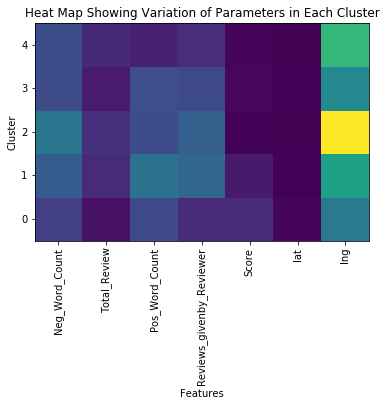

In [179]:
plt.pcolor(ClusterSummaryDistance)
plt.yticks(np.arange(0.5, len(ClusterSummaryDistance.index), 1), ClusterSummaryDistance.index)
plt.xticks(np.arange(0.5, len(ClusterSummaryDistance.columns), 1), ClusterSummaryDistance.columns,rotation=90)
plt.title("Heat Map Showing Variation of Parameters in Each Cluster")
plt.ylabel("Cluster")
plt.xlabel("Features")
plt.show()

In [184]:
ClusterCentroidSummary=ClusterCentroidSummary.take([1,2,3,4,5,6,7,8],axis=1)
column=['Nationality','Neg_Word_Count',
 'Total_Review',
 'Pos_Word_Count',
 'Reviews_givenby_Reviewer',
 'Score',
 'lat',
 'lng']

ClusterCentroidSummary.columns=column

In [185]:
ClusterCentroidSummary

,Nationality,Neg_Word_Count,Total_Review,Pos_Word_Count,Reviews_givenby_Reviewer,Score,lat,lng
0,Malaysia,10,7105,9,5,7.9,51.499046,-0.191707
1,United Kingdom,11,3826,6,1,6.7,51.504348,-0.033444
2,United Kingdom,6,4802,16,2,10.0,51.527847,-0.088947
3,Germany,9,2768,10,1,8.3,51.508354,0.019886
4,Malaysia,20,7491,20,11,8.3,51.510841,-0.078058
